In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load training (Jan–Oct) and full (Jan–Dec) datasets
train_df = pd.read_excel("Steel All Components JAn-Oct 2024 Prices.xlsx")
full_df = pd.read_excel("Steel All Component Prices.xlsx")

# Clean columns
train_df.columns = train_df.columns.str.strip()
full_df.columns = full_df.columns.str.strip()

In [ ]:
# Convert Date column
train_df['Date'] = pd.to_datetime(train_df['Date'])
full_df['Date'] = pd.to_datetime(full_df['Date'])


In [ ]:
# Extract Nov–Dec 2024 as test set
test_df = full_df[(full_df['Date'] >= '2024-11-01') & (full_df['Date'] <= '2024-12-31')]

In [ ]:
mild_features = [
    'Silicomanganese Price (INR)',  # ~0.79
    'Nickel Price (INR)',           # ~0.70 (nickel is usually not in mild steel, but if correlation is high, may keep)
    'Stainless Steel Price (INR)',  # ~0.59 (could reflect market linkage)
    'Mt Coke Price (INR)',          # ~0.48
    'Iron Price (INR)',             # ~0.21
    # Exclude Chromium & Steel Scrap due to low or negative correlation
]


In [ ]:
stainless_features = [
    'Silicomanganese Price (INR)',  # ~0.64
    'Mt Coke Price (INR)',          # ~0.51
    'Nickel Price (INR)',           # ~0.43
    'Iron Price (INR)',             # ~0.42
    'Chromium Price (INR)',         # ~0.24
    'Steel Scrap Price (INR)',      # ~0.15 (optional)
    'Molybdenum Price (INR)',       # ~0.11 (optional)
]


In [ ]:
# For Mild Steel
X_train_mild = train_df[mild_features]
X_test_mild = test_df[mild_features]
y_train_mild = train_df['Mild Steel Price (INR)']
y_test_mild = test_df['Mild Steel Price (INR)']

# For Stainless Steel
X_train_stainless = train_df[stainless_features]
X_test_stainless = test_df[stainless_features]
y_train_stainless = train_df['Stainless Steel Price (INR)']
y_test_stainless = test_df['Stainless Steel Price (INR)']


📈 Mild Steel Price Prediction

Random Forest: R2=-1.3930, MAE=612.10, RMSE=727.23, Accuracy=98.55%


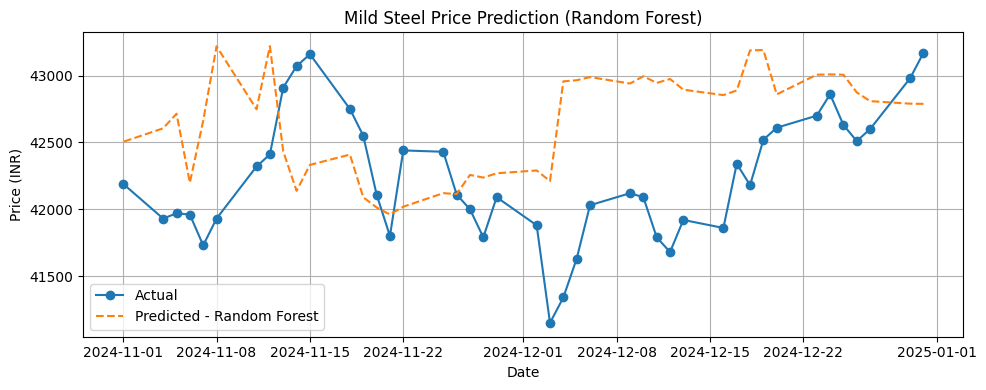

XGBoost: R2=-1.1897, MAE=538.43, RMSE=695.66, Accuracy=98.73%


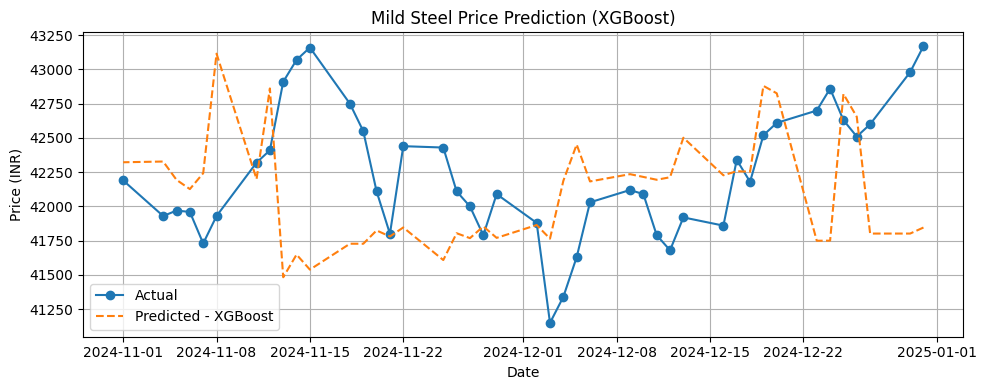

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Dictionary to store results
results = {}

# 1. Mild Steel Price Prediction
print("📈 Mild Steel Price Prediction\n")
results['Mild Steel'] = {}

for name, model in models.items():
    model.fit(X_train_mild, y_train_mild)
    y_pred = model.predict(X_test_mild)

    r2 = r2_score(y_test_mild, y_pred)
    mae = mean_absolute_error(y_test_mild, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_mild, y_pred))
    mape = mean_absolute_percentage_error(y_test_mild, y_pred)
    accuracy = 100 - mape

    results['Mild Steel'][name] = {
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Accuracy (%)': accuracy
    }

    print(f"{name}: R2={r2:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, Accuracy={accuracy:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 4))
    plt.plot(test_df['Date'], y_test_mild, label='Actual', marker='o')
    plt.plot(test_df['Date'], y_pred, label=f'Predicted - {name}', linestyle='--')
    plt.title(f"Mild Steel Price Prediction ({name})")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Combined Model (Averaged Predictions): R2=-0.8540, MAE=544.67, RMSE=640.12, Accuracy=98.71%


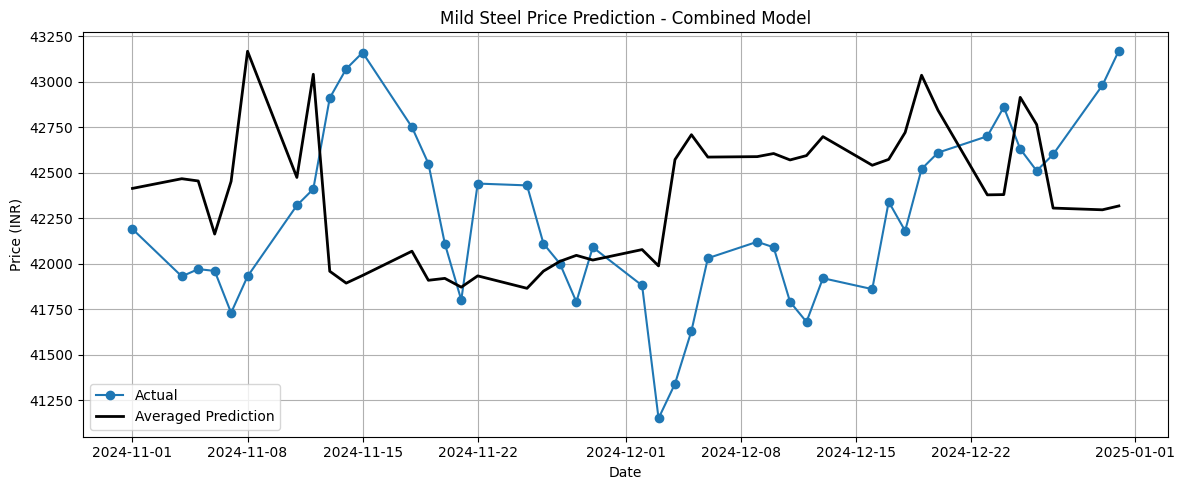

In [ ]:
# Combine predictions by averaging
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0)

rf_model.fit(X_train_mild, y_train_mild)
xgb_model.fit(X_train_mild, y_train_mild)

y_pred_rf = rf_model.predict(X_test_mild)
y_pred_xgb = xgb_model.predict(X_test_mild)

# Average predictions
y_pred_avg = (y_pred_rf + y_pred_xgb) / 2

# Calculate metrics for averaged prediction
r2_avg = r2_score(y_test_mild, y_pred_avg)
mae_avg = mean_absolute_error(y_test_mild, y_pred_avg)
rmse_avg = np.sqrt(mean_squared_error(y_test_mild, y_pred_avg))
mape_avg = mean_absolute_percentage_error(y_test_mild, y_pred_avg)
accuracy_avg = 100 - mape_avg

print(f"\nCombined Model (Averaged Predictions): R2={r2_avg:.4f}, MAE={mae_avg:.2f}, RMSE={rmse_avg:.2f}, Accuracy={accuracy_avg:.2f}%")

# Plot actual vs combined predicted
plt.figure(figsize=(12, 5))
plt.plot(test_df['Date'], y_test_mild, label='Actual', marker='o')

plt.plot(test_df['Date'], y_pred_avg, label='Averaged Prediction', linestyle='-', linewidth=2, color='black')
plt.title("Mild Steel Price Prediction - Combined Model")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📈 Stainless Steel Price Prediction

Random Forest: R2=-4.8556, MAE=6016.85, RMSE=6582.08, Accuracy=96.02%


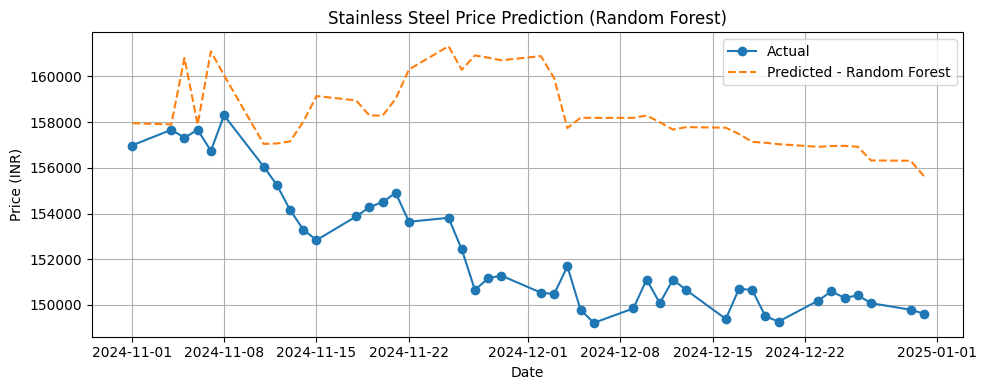

XGBoost: R2=-4.9220, MAE=6065.50, RMSE=6619.29, Accuracy=95.99%


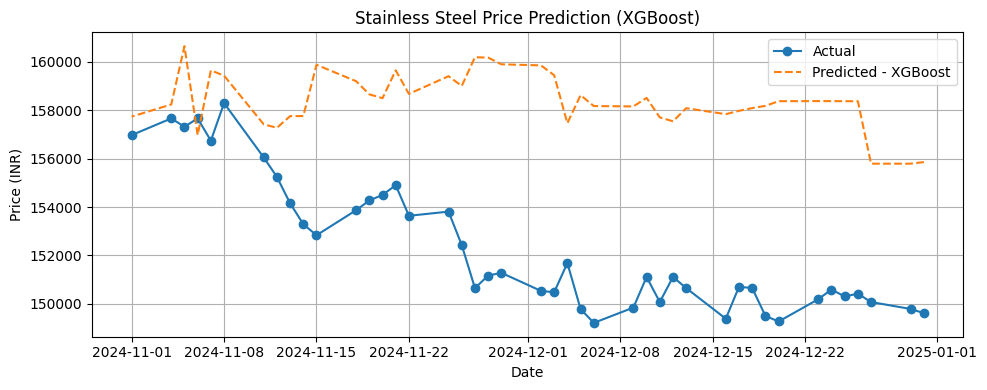

In [ ]:
# 2. Stainless Steel Price Prediction
print("\n📈 Stainless Steel Price Prediction\n")
results['Stainless Steel'] = {}

for name, model in models.items():
    model.fit(X_train_stainless, y_train_stainless)
    y_pred = model.predict(X_test_stainless)

    r2 = r2_score(y_test_stainless, y_pred)
    mae = mean_absolute_error(y_test_stainless, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_stainless, y_pred))
    mape = mean_absolute_percentage_error(y_test_stainless, y_pred)
    accuracy = 100 - mape

    results['Stainless Steel'][name] = {
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Accuracy (%)': accuracy
    }

    print(f"{name}: R2={r2:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, Accuracy={accuracy:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 4))
    plt.plot(test_df['Date'], y_test_stainless, label='Actual', marker='o')
    plt.plot(test_df['Date'], y_pred, label=f'Predicted - {name}', linestyle='--')
    plt.title(f"Stainless Steel Price Prediction ({name})")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


✅ Combined Model for Stainless Steel (Averaged Predictions):
R2=-4.3462, MAE=5705.70, RMSE=6289.26, Accuracy=96.23%


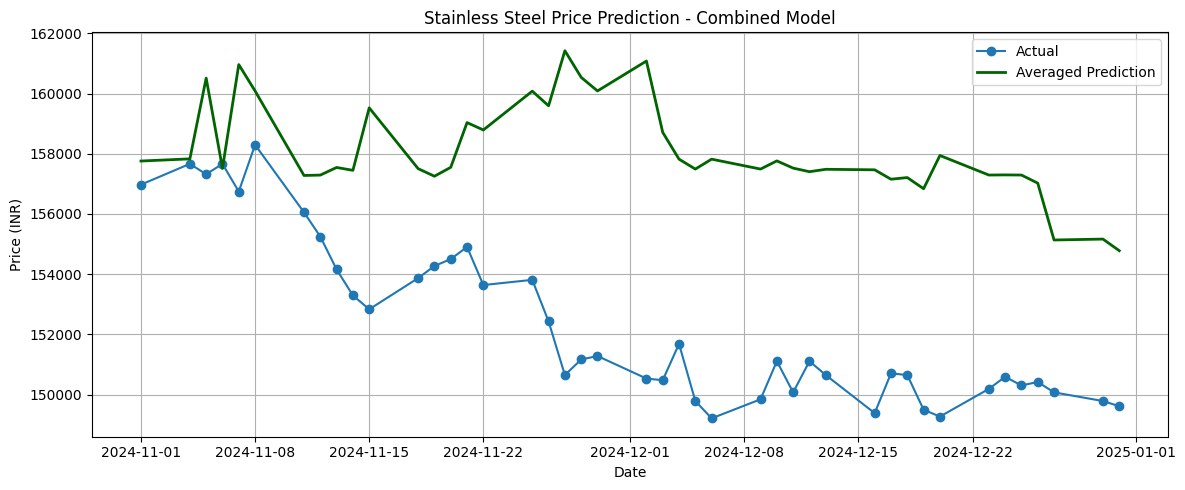

In [ ]:
# Combine predictions by averaging for Stainless Steel
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Fit models on stainless steel training data
rf_model.fit(X_train_stainless, y_train_stainless)
xgb_model.fit(X_train_stainless, y_train_stainless)

# Predict
y_pred_rf = rf_model.predict(X_test_stainless)
y_pred_xgb = xgb_model.predict(X_test_stainless)

# Average predictions
y_pred_avg = (y_pred_rf + y_pred_xgb) / 2

# Calculate metrics
r2_avg = r2_score(y_test_stainless, y_pred_avg)
mae_avg = mean_absolute_error(y_test_stainless, y_pred_avg)
rmse_avg = np.sqrt(mean_squared_error(y_test_stainless, y_pred_avg))
mape_avg = mean_absolute_percentage_error(y_test_stainless, y_pred_avg)
accuracy_avg = 100 - mape_avg

# Print metrics
print(f"\n✅ Combined Model for Stainless Steel (Averaged Predictions):")
print(f"R2={r2_avg:.4f}, MAE={mae_avg:.2f}, RMSE={rmse_avg:.2f}, Accuracy={accuracy_avg:.2f}%")

# Plot actual vs combined predicted
plt.figure(figsize=(12, 5))
plt.plot(test_df['Date'], y_test_stainless, label='Actual', marker='o')
plt.plot(test_df['Date'], y_pred_avg, label='Averaged Prediction', linestyle='-', linewidth=2, color='darkgreen')
plt.title("Stainless Steel Price Prediction - Combined Model")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

